In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from ast import literal_eval
import seaborn as sns

In [2]:
def HLA_cd8_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace(",", "").replace("'","").split(" ")

def cdr3_lst_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace("'","").split(" ")

def epitope_converter(x):
    #define format of datetime
    return [y for y in x.replace("[","").replace("]","").replace("\n","").split("'") if (y != '') & (y != ' ')]

def peptide_hla_converter(x):
    return re.findall("\w+\s{1}\w{1}\d+", x.replace("[","").replace("]","").replace("\n","").replace("'",""))

def literal_converter(val):
    # replace NaN with '' and perform literal eval on the rest
    return [] if val == '' else literal_eval(val)

converters = {'peptide_HLA_lst': peptide_hla_converter,
              'umi_count_lst_mhc': literal_eval,
              'umi_count_lst_TRA': literal_converter,'umi_count_lst_TRB': literal_converter,
              'cdr3_lst_TRA': cdr3_lst_converter,
              'cdr3_lst_TRB': cdr3_lst_converter,
              'HLA_lst_mhc': cdr3_lst_converter,'HLA_cd8': HLA_cd8_converter} #

In [3]:
def notnan(x):
    return x == x

In [4]:
def get_multiplets(df):
    #tmp = df[idx1 & idx2]
    dct = df.groupby(['ct','peptide_HLA']).gem.count() > 1
    idx = df.set_index(['ct','peptide_HLA']).index.map(dct)
    return idx.fillna(False)

In [5]:
OPT_THR = '../experiments/exp13/run1_archive/cat/eval_clonotypes/threshold/opt.csv'

In [6]:
VALID = '../experiments/exp13/run1_archive/cat/eval_clonotypes/valid_ct.csv'

In [7]:
HTO = '../experiments/exp13/run1_archive/brc/outfile.csv'
GEX = '../experiments/exp13/run1_archive/tcr/usable_gems.txt'
TCR = '../experiments/exp13/run1/tcr/cellranger_tot/outs/multi/vdj_t/all_contig_annotations.csv'
TCR_ARC = '../experiments/exp13/run1_archive/tcr/cellranger_tot/outs/multi/vdj_t/all_contig_annotations.csv'

In [8]:
tcr = pd.read_csv(TCR)
tcr_dct = tcr.groupby('barcode').is_cell.unique().apply(lambda x: x[0])
tcr_arc = pd.read_csv(TCR_ARC)
arc_dct = tcr_arc.groupby('barcode').is_cell.unique().apply(lambda x: x[0])
tcr_cell = pd.merge(arc_dct,tcr_dct, left_index=True,right_index=True, how='outer', suffixes=['_arc','_gex'])

In [9]:
gex = pd.read_csv(GEX, header=None, names=['gem'])

In [10]:
opt_thr = pd.read_csv(OPT_THR, index_col=0, header=None, names=['thr']).thr.dropna()
opt_thr.umi_count_cd8 = 0
opt_thr.delta_umi_cd8 = 0
opt_thr

umi_count_mhc    2.0
delta_umi_mhc    1.0
umi_count_cd8    0.0
delta_umi_cd8    0.0
umi_count_TRA   -0.0
delta_umi_TRA    0.0
umi_count_TRB   -0.0
delta_umi_TRB   -0.0
Name: thr, dtype: float64

# Load

In [12]:
os1 = pd.read_csv(VALID, converters=converters)

In [13]:
os1.fillna({'umi_count_mhc':0, 'delta_umi_mhc':0, 'umi_count_mhc_rel':0,
           'umi_count_cd8':0, 'delta_umi_cd8':0,
           'umi_count_TRA':0, 'delta_umi_TRA':0,
           'umi_count_TRB':0, 'delta_umi_TRB':0,
           'cdr3_TRA':'','cdr3_TRB':''}, inplace=True)

In [15]:
hto = pd.read_csv(HTO, skiprows=1, header=None,
                  names=['gem','seurat','umi_count_hto','feature_rna','count_hto','feature_hto','hto_max_id','hto_sec_id',
                         'hto_margin','hto_classification','hto_global_class','hash_id'])

# Process

In [16]:
df = pd.merge(os1, hto, how='left', on='gem')
df.hto_global_class.fillna('Singlet', inplace=True)
df['gex'] = df.gem.isin(gex.gem)
#df['gex'] = df.gem.map(tcr_dct)
df = pd.merge(df, tcr_cell, left_on='gem',right_index=True)

# Main

In [22]:
grp = df.groupby('ct').sample_id.unique()

In [25]:
grp[grp.apply(len) > 1]

ct
1.0            [10.0, 4.0, 9.0, 1.0, 2.0, 8.0, 7.0]
2.0                 [10.0, 7.0, 6.0, 9.0, 2.0, 1.0]
3.0       [9.0, 4.0, 10.0, 8.0, 6.0, 1.0, 2.0, 7.0]
4.0                      [8.0, 10.0, 5.0, 6.0, 1.0]
5.0            [3.0, 10.0, 2.0, 1.0, 9.0, 7.0, 4.0]
                            ...                    
6843.0                             [8.0, 10.0, 7.0]
6872.0                                  [10.0, 2.0]
6891.0                                  [2.0, 10.0]
6950.0                                  [7.0, 10.0]
6958.0                             [10.0, 7.0, 2.0]
Name: sample_id, Length: 192, dtype: object

(array([3.076e+03, 1.430e+02, 2.900e+01, 0.000e+00, 1.000e+01, 3.000e+00,
        0.000e+00, 4.000e+00, 2.000e+00, 1.000e+00]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <a list of 10 Patch objects>)

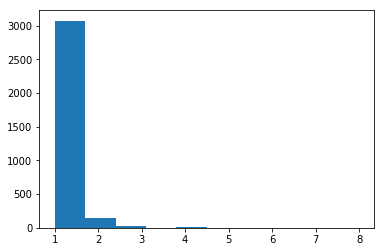

In [26]:
plt.hist(grp.apply(len))

In [31]:
tmp = df.groupby(['ct','ct_pep']).sample_id.unique().to_frame()

In [34]:
tmp

,,sample_id,n_samples
ct,ct_pep,,
1.0,VLEETSVML A0201,"[10.0, 4.0, 9.0, 1.0, 2.0, 8.0, 7.0]",7
2.0,RVRAYTYSK A0301,"[10.0, 7.0, 6.0, 9.0, 2.0, 1.0]",6
3.0,TPRVTGGGAM B0702,"[9.0, 4.0, 10.0, 8.0, 6.0, 1.0, 2.0, 7.0]",8
4.0,RPHERNGFTVL B0702,"[8.0, 10.0, 5.0, 6.0, 1.0]",5
5.0,VLEETSVML A0201,"[3.0, 10.0, 2.0, 1.0, 9.0, 7.0, 4.0]",7
...,...,...,...
5587.0,VLEETSVML A0201,"[10.0, 3.0, 2.0, 8.0]",4
5602.0,RVRAYTYSK A0301,[2.0],1
5609.0,TPRVTGGGAM B0702,"[7.0, 10.0, 2.0]",3


In [33]:
tmp['n_samples'] = tmp.sample_id.apply(len)

In [36]:
tmp.reset_index(inplace=True)

In [37]:
tmp

,ct,ct_pep,sample_id,n_samples
0,1.0,VLEETSVML A0201,"[10.0, 4.0, 9.0, 1.0, 2.0, 8.0, 7.0]",7
1,2.0,RVRAYTYSK A0301,"[10.0, 7.0, 6.0, 9.0, 2.0, 1.0]",6
2,3.0,TPRVTGGGAM B0702,"[9.0, 4.0, 10.0, 8.0, 6.0, 1.0, 2.0, 7.0]",8
3,4.0,RPHERNGFTVL B0702,"[8.0, 10.0, 5.0, 6.0, 1.0]",5
4,5.0,VLEETSVML A0201,"[3.0, 10.0, 2.0, 1.0, 9.0, 7.0, 4.0]",7
...,...,...,...,...
98,5587.0,VLEETSVML A0201,"[10.0, 3.0, 2.0, 8.0]",4
99,5602.0,RVRAYTYSK A0301,[2.0],1
100,5609.0,TPRVTGGGAM B0702,"[7.0, 10.0, 2.0]",3
101,5673.0,RVRAYTYSK A0301,[4.0],1


In [38]:
tmp.groupby('ct_pep').n_samples.unique()

ct_pep
CLGGLLTMV A0201                  [5, 1]
FLYALALLL A0201                     [1]
RPHERNGFTVL B0702       [5, 4, 6, 3, 1]
RPPIFIRRL B0702               [3, 1, 6]
RVRAYTYSK A0301         [6, 4, 3, 2, 1]
TPRVTGGGAM B0702     [8, 5, 2, 1, 3, 4]
TPSVSSSISSL B0702                   [1]
VLEETSVML A0201               [7, 2, 4]
YVLDHLIVV A0201               [3, 1, 2]
Name: n_samples, dtype: object